# Step 0: Import Required Packages 

#### If the cell below doesn't run then do 'pip install rpy2' 
#### Change the paths for os.environ below to match your R folder directory and version if you get error messages

In [1]:
import os
import rpy2

try:
    import rpy2.robjects as robjects
except:
    os.environ["R_HOME"] = r"C:\Program Files\R\R-4.0.2"
    os.environ["PATH"]   = r"C:\Program Files\R\R-4.0.2\bin\x64" + ";" + os.environ["PATH"]
    import rpy2.robjects as robjects
    
import rpy2.robjects.packages as rpackages
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.vectors import StrVector
from rpy2.robjects import FloatVector, Formula

#### Run pip install tabulate if the cell below does not run

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
import math
from sklearn.model_selection import GridSearchCV
import time

from IPython.display import HTML, display
import tabulate

# Step 1: Read the files

We first read in the low dimensional dataset and high dimensional dataset from the data folder. These have feature columns with a prefix ‘V’, a treatment/control column, and a continuous response Y. 

For this project, we know that the true ATE for the low dimensional data is 2.5, and for the high dimensional data it’s -3.

In [115]:
lowDim_dataset = pd.read_csv('../data/lowDim_dataset.csv')
highDim_dataset = pd.read_csv('../data/highDim_dataset.csv')

lowDim_true_ATE = 2.5
highDim_true_ATE = -3

# Step 2: Calculate Propensity and Linear Propensity Scores

To calculate the propensity scores, we first need to fit a GBM classifier on the features and the binary response A, which indicates if a person is in the control group (0) or the treatment group (1). To get the optimal parameters for the GBM without overfitting, we performed a grid search. The two cells below are commented out due to the long runtime it takes to perform the grid search. 

In [4]:
#low dim grid search (commented out since it takes a few minutes to run)

#X=lowDim_dataset.iloc[:,2:].values
#A=lowDim_dataset['A'].values
#Y=lowDim_dataset['Y'].values

#params = {'learning_rate':[0.01,0.05,0.1,0.5], 'max_depth': [1,2,3,4], 'n_estimators':[50,100,150],
#          'min_samples_leaf':[1,3,5],'min_samples_split':[2,4,6]}
#gscv = GridSearchCV(GradientBoostingClassifier(),params,cv=5).fit(X,A)
#gscv.best_params_

#output: {'learning_rate': 0.01,
# 'max_depth': 2,
# 'min_samples_leaf': 1,
# 'min_samples_split': 2,
# 'n_estimators': 150}

In [5]:
#high dim grid search (commented out since it takes a few minutes to run)

#X=highDim_dataset.iloc[:,2:].values
#A=highDim_dataset['A'].values
#Y=highDim_dataset['Y'].values

#params = {'learning_rate':[0.01,0.05,0.1,0.5], 'max_depth': [1,2,3,4], 'n_estimators':[50,100,150],
#          'min_samples_leaf':[1,3,5],'min_samples_split':[2,4,6]}
#gscv = GridSearchCV(GradientBoostingClassifier(),params,cv=5).fit(X,A)
#gscv.best_params_


#output: {'learning_rate': 0.05,
# 'max_depth': 1,
# 'min_samples_leaf': 5,
# 'min_samples_split': 2,
# 'n_estimators': 100}

Here we define the logit function, which is used to get linear propensity scores from the propensity scores.

In [116]:
def logit(x):
    return math.log(x/(1-x))

Now we will use the parameters we got from the grid search to get the propensity scores and linear propensity scores from the low and high dimensional datasets. We save the scores to csv files in the output folder.

Note that the propensity score of an individual is the class probability that it is the individual is in the treatment group, and the probabilities are determined by the GBM classifier.

### Low Dimensional Dataset

In [117]:
X=lowDim_dataset.iloc[:,2:].values
A=lowDim_dataset['A'].values
Y=lowDim_dataset['Y'].values

gbm = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 2, min_samples_leaf = 1,
                                min_samples_split = 2, n_estimators = 150).fit(X,A)

low_dim_propensity_scores = [x[1] for x in gbm.predict_proba(X)]
low_dim_linear_propensity_scores = [logit(x) for x in low_dim_propensity_scores]

In [118]:
lowDim_dataset_propensity = lowDim_dataset.copy(deep=True)
lowDim_dataset_propensity['propensity_score'] = low_dim_propensity_scores

In [119]:
lowDim_dataset_linear_propensity = lowDim_dataset.copy(deep=True)
lowDim_dataset_linear_propensity['linear_propensity_score'] = low_dim_linear_propensity_scores

In [120]:
pd.DataFrame({'propensity_scores':low_dim_propensity_scores}).to_csv('../output/low_dim_propensity_scores.csv')
pd.DataFrame({'linear_propensity_scores':low_dim_linear_propensity_scores}).to_csv('../output/low_dim_linear_propensity_scores.csv')

### High Dimensional Dataset

In [121]:
X=highDim_dataset.iloc[:,2:].values
A=highDim_dataset['A'].values
Y=highDim_dataset['Y'].values

gbm = GradientBoostingClassifier(learning_rate = 0.05, max_depth = 1, min_samples_leaf = 5,
                                min_samples_split = 2, n_estimators = 100).fit(X,A)

high_dim_propensity_scores = [x[1] for x in gbm.predict_proba(X)]
high_dim_linear_propensity_scores = [logit(x) for x in high_dim_propensity_scores]

In [122]:
highDim_dataset_propensity = highDim_dataset.copy(deep=True)
highDim_dataset_propensity['propensity_score'] = high_dim_propensity_scores

In [123]:
highDim_dataset_linear_propensity = highDim_dataset.copy(deep=True)
highDim_dataset_linear_propensity['linear_propensity_score'] = high_dim_linear_propensity_scores

In [124]:
pd.DataFrame({'propensity_scores':high_dim_propensity_scores}).to_csv('../output/high_dim_propensity_scores.csv')
pd.DataFrame({'linear_propensity_scores':high_dim_linear_propensity_scores}).to_csv('../output/high_dim_linear_propensity_scores.csv')

# Step 3: Perform Full Matching

Full matching is a way to break the dataset into subsets so that each subset has at least one treatment member and at least one control member. Subsets are created based on how close people are in terms of a specific distance metric, and the subsets do not have to be the same size. Every individual must be placed into a subset.

In particular, full matching creates subsets so that the sum of the distances between all pairs of treated and control individuals within each matched set, across all matched sets, is minimized.

For a more formal explanation of how full matching works, let $T$ and $C$ denote the treatment and control sets of individuals respectively. Suppose that for every pair $(i,j)$ with $i \in T$ and $j \in C$, a distance $\delta_{ij} \in \mathbb{R}^+$ is given, where smaller values of $\delta$ would indicate more desirable matches. 

Let $S$ be a mapping of $T \cup C$ into $\{1,...,K\}$ ($K$ is the number of subsets that $S$ maps values to) where for each matched subset $M$, $M=S^{-1}[k]$ $(1 \leq k \leq K)$ is such that $min(|M \cap T|, |M \cap C|)=1$ and $\delta_{ij} <\infty$ for all i,j.

Then given a dataset of control individuals $C$, treatment individuals $T$, and distances $\delta$, a full match $S'$ minimizes the below sum, which is the sum of distances between all pairs of treated and control individuals across all matches for a fixed matching function $S$.

$$ \sum_{i \in T, S(i) > 0}^{}  \sum_{j \in C, S(i)=S(j)}^{}  \delta_{ij}$$


The motivation behind full matching is that people within the same subset are ideally similar enough to each other that their response values can serve as counterfactuals for each other (e.g. if person A received treatment and is in the same subset as person B who was under control, then the response value for B would be close to the response value for A if A had been under control instead of treatment and vice versa). Once we’ve created the subsets, we can estimate the ATE by taking a weighted average of all of the differences between mean treatment response and mean control response within the subsets. 

Note that one problem with full matching is that it sometimes leads to subsets with widely varying ratios of treatment to control since we only require that at least one treatment or control be in each set. For example, it is possible to have one subset with five treatment and five control individuals, and another subset to have one treatment and eight control individuals. Hence, this possible large variance in ratios can lead to a large variance of differences between mean treatment response and mean control response across all of the subsets.

### Set Up rpy2 (Python Interface to R)

To implement full matching, we use the fullmatch function from the R package optmatch. To use the function, we first set up the Python interface to R which will install the necessary packages from CRAN.

In [125]:
%%capture 
utils = importr('utils')
utils.chooseCRANmirror(ind=1)
packnames = ('optmatch')


In [126]:
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))

R[write to console]: Installing packages into 'C:/Users/Elise Nguyen/OneDrive/Documents/R/win-library/4.0'
(as 'lib' is unspecified)



In [127]:
%%capture 
utils.chooseCRANmirror(ind=1)
robjects.r(f'install.packages("{"optmatch"}")')

In [128]:
optmatch = rpackages.importr('optmatch')

Here we convert the pandas dataframes to R dataframes which are compatible with the fullmatch function and also keep track of the runtime it takes to do the conversion. 

The try-except block is to take into account of the fact that Windows and Mac do not have the same latest version of the rpy2 package, and the two different versions have different syntax for dataframe conversion.

In [129]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    try:
        lowDim_R_runtime = time.time()
        lowDim_dataset_R = robjects.conversion.py2rpy(lowDim_dataset)
        lowDim_R_runtime = time.time()-lowDim_R_runtime
        
        lowDim_propensity_R_runtime = time.time()
        lowDim_dataset_propensity_R = robjects.conversion.py2rpy(lowDim_dataset_propensity)
        lowDim_propensity_R_runtime = time.time()-lowDim_propensity_R_runtime
        
        lowDim_linear_propensity_R_runtime = time.time()
        lowDim_dataset_linear_propensity_R = robjects.conversion.py2rpy(lowDim_dataset_linear_propensity)
        lowDim_linear_propensity_R_runtime = time.time()-lowDim_linear_propensity_R_runtime
        
    except:
        lowDim_R_runtime = time.time()
        lowDim_dataset_R = pandas2ri.py2ri(lowDim_dataset)
        lowDim_R_runtime = time.time()-lowDim_R_runtime
        
        lowDim_propensity_R_runtime = time.time()
        lowDim_dataset_propensity_R = pandas2ri.py2ri(lowDim_dataset_propensity)
        lowDim_propensity_R_runtime = time.time()-lowDim_propensity_R_runtime
        
        lowDim_linear_propensity_R_runtime = time.time()
        lowDim_dataset_linear_propensity_R = pandas2ri.py2ri(lowDim_dataset_linear_propensity)
        lowDim_linear_propensity_R_runtime = time.time()-lowDim_linear_propensity_R_runtime

In [99]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    try:
        highDim_R_runtime = time.time()
        highDim_dataset_R = robjects.conversion.py2rpy(highDim_dataset)
        highDim_R_runtime = time.time()-highDim_R_runtime
        
        highDim_propensity_R_runtime = time.time()
        highDim_dataset_propensity_R = robjects.conversion.py2rpy(highDim_dataset_propensity)
        highDim_propensity_R_runtime = time.time()-highDim_propensity_R_runtime
        
        highDim_linear_propensity_R_runtime = time.time()
        highDim_dataset_linear_propensity_R = robjects.conversion.py2rpy(highDim_dataset_linear_propensity)
        highDim_linear_propensity_R_runtime = time.time()-highDim_linear_propensity_R_runtime
        
    except:
        highDim_R_runtime = time.time()
        highDim_dataset_R = pandas2ri.py2ri(highDim_dataset)
        highDim_R_runtime = time.time()-highDim_R_runtime
        
        highDim_propensity_R_runtime = time.time()
        highDim_dataset_propensity_R = pandas2ri.py2ri(highDim_dataset_propensity)
        highDim_propensity_R_runtime = time.time()-highDim_propensity_R_runtime
        
        highDim_linear_propensity_R_runtime = time.time()
        highDim_dataset_linear_propensity_R = pandas2ri.py2ri(highDim_dataset_linear_propensity)
        highDim_linear_propensity_R_runtime = time.time()-highDim_linear_propensity_R_runtime

### Method 1: Mahalanobis

The Mahalanobis distance matrix is given by
$$D_{ij} = (X_i-X_j)^T\Sigma^{-1}(X_i-X_j)$$
where $\Sigma$ is the covariance matrix of $X$ in the pooled treatment and full control groups.

Mahalanobis does not require propensity scores and instead uses the features and covariance matrix of the pooled treatment and full control groups to create a distance matrix. Intuitively, the Mahalanobis distance measures the distance of two points relative to the centroid of all of the data points with the axes being determined by the direction of greatest variance in the cloud of points. That is, we let the data itself determine the coordinate system. For uncorrelated variables, the covariance matrix becomes a diagonal matrix, so the Mahalanobis distance between two points is equal to their standardized Euclidean distance in this case. 

#### a. Low Dim Data

Mahalanbois generally works well, both in terms of runtime and having a low error, when there are relatively few covariates because the covariance matrix is easier to invert. In this case, it works well because it takes advantage of the correlations between different features for its distance calculation. 

In [130]:
start = time.time()
full_match_Mahalanobis_factor = optmatch.fullmatch(optmatch.match_on(Formula('A~.-Y'),data=lowDim_dataset_R,method='mahalanobis'),data=lowDim_dataset_R)
lowDim_dataset['assign'] = list(full_match_Mahalanobis_factor)

In [131]:
#compute ATE
ATE_vec = []
weights = []

for i in range(max(list(full_match_Mahalanobis_factor))):
    temp = lowDim_dataset.loc[lowDim_dataset['assign']==i+1]
    
    treatment_Y = temp.loc[temp['A']==1]['Y'].values
    control_Y = temp.loc[temp['A']==0]['Y'].values
    
    ATE_vec.append(np.mean(treatment_Y)-np.mean(control_Y))
    weights.append(len(treatment_Y)+len(control_Y))

lowDim_mahalanobis_est_ATE = np.average(ATE_vec, weights = weights)

end = time.time()
lowDim_mahalanobis_match_runtime = end-start

In [132]:
#runtime is time to convert to R data frame + time to do matching
lowDim_mahalanobis_runtime = "{:,.3f}".format(lowDim_R_runtime+lowDim_mahalanobis_match_runtime)
lowDim_mahalanobis_runtime

'1.042'

In [133]:
lowDim_mahalanobis_error = abs(lowDim_true_ATE-lowDim_mahalanobis_est_ATE)
lowDim_mahalanobis_error ="{:,.3f}".format(lowDim_mahalanobis_error)
print(lowDim_mahalanobis_error)

0.406


#### b. High Dim Data

Mahalanobis has a higher error on the high dimensional dataset because the creation of the distance matrix views all of the interactions between features as equally important. Hence, full matching with Mahalanobis tries to capture more of the multi way interactions, so it does not perform well when there are too many interactions to keep track of for the matching criteria. In terms of runtime, Mahalanobis also takes a significantly long time on high dimensional data due to the complexity of inverting the covariance matrix.

In [135]:
start = time.time()
full_match_Mahalanobis_factor = optmatch.fullmatch(optmatch.match_on(Formula('A~.-Y'),data=highDim_dataset_R,method='mahalanobis'),data=highDim_dataset_R)
highDim_dataset['assign'] = list(full_match_Mahalanobis_factor)

In [136]:
#compute ATE
ATE_vec = []
weights = []

for i in range(max(list(full_match_Mahalanobis_factor))):
    temp = highDim_dataset.loc[highDim_dataset['assign']==i+1]
    
    treatment_Y = temp.loc[temp['A']==1]['Y'].values
    control_Y = temp.loc[temp['A']==0]['Y'].values
    
    ATE_vec.append(np.mean(treatment_Y)-np.mean(control_Y))
    weights.append(len(treatment_Y)+len(control_Y))
    
highDim_mahalanobis_est_ATE = np.average(ATE_vec, weights=weights)
    
end = time.time()
highDim_mahalanobis_match_runtime = end-start

In [137]:
highDim_mahalanobis_runtime = "{:,.3f}".format(highDim_R_runtime+highDim_mahalanobis_match_runtime)
highDim_mahalanobis_runtime

'87.579'

In [138]:
highDim_mahalanobis_error = abs(highDim_true_ATE-highDim_mahalanobis_est_ATE)
highDim_mahalanobis_error= "{:,.3f}".format(highDim_mahalanobis_error)
print(highDim_mahalanobis_error)

1.447


### Method 2: Propensity Score

The distance of Propensity Score is defined as:
                                            $$D_{ij} = |e_{i} − e_{j} |$$
where $e_{k}$ is the propensity score for individual k

Propensity scores are created with a GBM classifier fitted on the features and treatment/control column. The propensity scores are class probabilities of each individual being in the treatment group. Since GBM adaptively chooses variables to include as part of its algorithm, we fit it on all of the features.


#### Motivation behind propensity scores: 
Considering an idealized situation in which the treatment and comparison groups are similar on all background characteristics (as is attained in a randomized experiment). In nonexperimental studies, researchers might aim to find for each treated individual a comparison individual who looks exactly the same as the treated individual on all observed pretreatment covariates. Thus, assuming no hidden bias, any difference in outcomes within these pairs could be attributed to the treatment and not to any other differences between the treated and comparison individuals. <br> 


#### Benefits of propensity score matching:
(a) Facilitate this matching by collapsing the set of observed background covariates into a single summary measure (the propensity score), representing an estimate of the probability of receiving the treatment. Then, instead of trying to find treated and comparison individuals with the same values of all covariates, one can match each treated individual to a comparison individual with a similar value of the propensity score. 

If treatment assignment is independent of the potential outcomes given the full set of covariates (treatment assignment is unconfounded), then it is also independent of the potential outcomes given the propensity score. This implies that the benefits of matching on all covariates individually are also attained when matching on the propensity score. In other words, within a set of treated and comparison individuals with similar propensity scores, the treatment and comparison groups will also have similar distributions of all the covariates that went into the propensity score. The success of the matching procedure is then examined by comparing the distributions of the covariates in the resulting matched treatment and comparison groups.

(b) Reduced bias in the estimation of causal effects using nonexperimental data, partly through reduced reliance on the outcome model itself (e.g., violations of the assumption of a normal distribution or linearity) <br>
(c) Intuitive and easy explanation to nontechnical audiences <br>

#### a. Low Dim Data

Propensity score didn't perform as well on low dimensional data set as high dimensional one. <br> 
The problem maybe that full matching sometimes leads to matched sets with widely varying ratios of treated to comparison individuals, which can lead to large variance of the resulting effect estimates.<br>
With regular propensity scores the ratio of the subsets for the low dim datasets have a somewhat high variance than for high dim datasets, as seen in the treatment/control ratio list below: 


In [140]:
start = time.time()
full_match_propensity_factor = optmatch.fullmatch(optmatch.match_on(Formula('A~propensity_score'),data=lowDim_dataset_propensity_R,method='euclidean'),data=lowDim_dataset_propensity_R)
lowDim_dataset_propensity['assign'] = list(full_match_propensity_factor)

In [141]:
#compute ATE
ATE_vec = []
weights = []
ratio_list = []

for i in range(max(list(full_match_propensity_factor))):
    temp = lowDim_dataset_propensity.loc[lowDim_dataset_propensity['assign']==i+1]
    
    treatment_Y = temp.loc[temp['A']==1]['Y'].values
    control_Y = temp.loc[temp['A']==0]['Y'].values
    
    ATE_vec.append(np.mean(treatment_Y)-np.mean(control_Y))
    weights.append(len(treatment_Y)+len(control_Y))
    ratio_list.append([len(treatment_Y),len(control_Y)])
    
lowDim_propensity_est_ATE = np.average(ATE_vec, weights=weights)
    
end = time.time()
lowDim_propensity_match_runtime = end-start
print(ratio_list[0:10])  

[[1, 2], [18, 1], [1, 1], [1, 1], [1, 8], [1, 16], [1, 1], [2, 1], [1, 1], [1, 2]]


In [142]:
lowDim_propensity_runtime = "{:,.3f}".format(lowDim_propensity_R_runtime+lowDim_propensity_match_runtime)
lowDim_propensity_runtime

'0.902'

In [143]:
lowDim_propensity_error = abs(lowDim_true_ATE-lowDim_propensity_est_ATE)
lowDim_propensity_error ="{:,.3f}".format(lowDim_propensity_error)
print(lowDim_propensity_error)

0.888


#### b. High Dim Data

Propensity scores performed well on High dim data set. 

This is because, as mentioned in the Benefits section above, propensity scores facilitate the matching by collapsing the set of observed background covariates into a single summary measure (the propensity score), representing an estimate of the probability of receiving the treatment. Since this is the high dimensional data set, it works particularly well to collapse all these covariates into the propensity score.


In [144]:
start = time.time()
full_match_propensity_factor = optmatch.fullmatch(optmatch.match_on(Formula('A~propensity_score'),data=highDim_dataset_propensity_R,method='euclidean'),data=highDim_dataset_propensity_R)
highDim_dataset_propensity['assign'] = list(full_match_propensity_factor)

The ratio list below shows ratios of treated to comparison individuals, which is more consistent around 1 than those in the low dim data set, which should result in less variance and is possibly why propensity scores performed better for high dim than low dim. 

In [145]:
#compute ATE
ATE_vec = []
weights = []
ratio_list = []

for i in range(max(list(full_match_propensity_factor))):
    temp = highDim_dataset_propensity.loc[highDim_dataset_propensity['assign']==i+1]
    
    treatment_Y = temp.loc[temp['A']==1]['Y'].values
    control_Y = temp.loc[temp['A']==0]['Y'].values
    
    ATE_vec.append(np.mean(treatment_Y)-np.mean(control_Y))
    weights.append(len(treatment_Y)+len(control_Y))
    ratio_list.append([len(treatment_Y),len(control_Y)])

highDim_propensity_est_ATE = np.average(ATE_vec, weights=weights)    

end = time.time()
highDim_propensity_match_runtime = end-start
print(ratio_list[0:10])

[[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]]


In [146]:
highDim_propensity_runtime = "{:,.3f}".format(highDim_propensity_R_runtime+highDim_propensity_match_runtime)
highDim_propensity_runtime

'8.703'

In [147]:
highDim_propensity_error = abs(highDim_true_ATE-highDim_propensity_est_ATE)
highDim_propensity_error ="{:,.3f}".format(highDim_propensity_error)
print(highDim_propensity_error)

0.292


### Method 3: Linear Propensity Score

Defined as:                         
                        $$D_{ij} = |logit(e_{i})−logit(e_{j})|$$
Obtained by applying the logit function on the propensity scores


Matching on the linear propensity score can be particularly effective in terms of reducing bias

#### a. Low Dim Data

Linear Propensity Score didn't perform as well for low dimension as high dimensional data set, possibly for the same reason discussed above for standard Propensity Score <br>
We can see ratio_list print out below that the ratio between treatment and controls in each group is not very consistent around 1. 

In [148]:
start = time.time()
full_match_linear_propensity_factor = optmatch.fullmatch(optmatch.match_on(Formula('A~linear_propensity_score'),data=lowDim_dataset_linear_propensity_R,method='euclidean'),data=lowDim_dataset_linear_propensity_R)
lowDim_dataset_linear_propensity['assign'] = list(full_match_linear_propensity_factor)

In [149]:
#compute ATE
ATE_vec = []
weights = []
ratio_list = []

for i in range(max(list(full_match_linear_propensity_factor))):
    temp = lowDim_dataset_linear_propensity.loc[lowDim_dataset_linear_propensity['assign']==i+1]
    
    treatment_Y = temp.loc[temp['A']==1]['Y'].values
    control_Y = temp.loc[temp['A']==0]['Y'].values
    
    ATE_vec.append(np.mean(treatment_Y)-np.mean(control_Y))
    weights.append(len(treatment_Y)+len(control_Y))
    ratio_list.append([len(treatment_Y),len(control_Y)])
    
lowDim_linear_propensity_est_ATE = np.average(ATE_vec, weights=weights)

end = time.time()
lowDim_linear_propensity_match_runtime = end-start
print(ratio_list[0:10])

[[1, 1], [1, 1], [1, 2], [1, 7], [1, 2], [1, 17], [1, 1], [1, 1], [1, 1], [1, 2]]


In [150]:
lowDim_linear_propensity_runtime = "{:,.3f}".format(lowDim_linear_propensity_R_runtime+lowDim_linear_propensity_match_runtime)
lowDim_linear_propensity_runtime

'0.587'

In [151]:
lowDim_linear_propensity_error = abs(lowDim_true_ATE-lowDim_linear_propensity_est_ATE)
lowDim_linear_propensity_error ="{:,.3f}".format(lowDim_linear_propensity_error)
print(lowDim_linear_propensity_error)

0.976


#### b. High Dim Data

Linear Propensity score performed well for high dimensional data set as explained above for standard propensity score. In addition, linear propensity score is effective in reduceing bias.

In [159]:
start = time.time()
full_match_linear_propensity_factor = optmatch.fullmatch(optmatch.match_on(Formula('A~linear_propensity_score'),data=highDim_dataset_linear_propensity_R,
                                                                           method='euclidean'),data=highDim_dataset_linear_propensity_R)
highDim_dataset_linear_propensity['assign'] = list(full_match_linear_propensity_factor)

In [160]:
#compute ATE
ATE_vec = []
weights = []
ratio_list = []
for i in range(max(list(full_match_linear_propensity_factor))):
    temp = highDim_dataset_linear_propensity.loc[highDim_dataset_linear_propensity['assign']==i+1]
    
    treatment_Y = temp.loc[temp['A']==1]['Y'].values
    control_Y = temp.loc[temp['A']==0]['Y'].values
    
    ATE_vec.append(np.mean(treatment_Y)-np.mean(control_Y))
    weights.append(len(treatment_Y)+len(control_Y))
    ratio_list.append([len(treatment_Y),len(control_Y)])

highDim_linear_propensity_est_ATE=np.average(ATE_vec, weights=weights)

end = time.time()
highDim_linear_propensity_match_runtime = end-start
print(ratio_list[0:10])

[[1, 1], [2, 1], [1, 1], [1, 1], [2, 1], [1, 1], [2, 1], [1, 1], [2, 1], [1, 1]]


In [161]:
highDim_linear_propensity_runtime = "{:,.3f}".format(highDim_linear_propensity_R_runtime+highDim_linear_propensity_match_runtime)
highDim_linear_propensity_runtime

'12.074'

In [162]:
highDim_linear_propensity_error = abs(highDim_true_ATE-highDim_linear_propensity_est_ATE)
highDim_linear_propensity_error ="{:,.3f}".format(highDim_linear_propensity_error)
print(highDim_linear_propensity_error)

0.232


## Step 4: Inverse Propensity Weighting Algorithm

When comparing the exposure effects between treatment groups, if we ignored those confounding factors, the effect estimates will be biased. Inverse probability weighting (IPW) based on the marginal structure model is an important method that can be used to estimate the effect of observational data processing and can address a very large number of confounding variables. Applying this weight when conducting statistical tests or regression models reduces or removes the impact of confounders. For inverse probability of treatment weighting (IPTW), we use propensity score as inverse weights in estimates of the ATE. 

The weight $w_i$ is 
$$w_i = \frac{T_i}{\hat{e_i}} + \frac{1 - T_i}{1 - \hat{e_i}} $$
where $\hat{e_i}$ is the estimated propensity score for individual $i$; $T_i$ is the treatment groups: $T_0$ is the controlled group and $T_1$ is after treatment group

In this project, IPW does not work well in both low and high dimensional datasets.The reason might be the limitations of the Inverse Probability Weighted Estimator (IPWE). It can be unstable if estimated propensities are small. If the probability of either treatment assignment is small, then the logistic regression model can become unstable around the tails causing the IPWE to also be less stable. IPW needs to meet some prerequisites when applying, such as no omissions and unobserved confounding factors, non-negativity assumptions, stable unit processing value assumptions, and correct weight estimation models.

The estimate ATE using IPW is 
$$\hat{\Delta}_{IPW} = N^{-1} (\sum_{i \in treated}{w_i Y_i} -\sum_{i\in controlled}{w_i Y_i} )$$

### 1. Reset data & Define Functions

In [79]:
lowDim_dataset = pd.read_csv('../data/lowDim_dataset.csv')
highDim_dataset = pd.read_csv('../data/highDim_dataset.csv')

In [80]:
def ipw_ate(dataset):
    treated = 0
    controlled = 0
    for i in range(dataset.shape[0]):
        if dataset['A'][i] == 1:
            treated += dataset['Y'][i] * dataset['weight'][i]
        else:
            controlled += dataset['Y'][i] * dataset['weight'][i]

    print(treated - controlled)
    ate = (treated - controlled)/dataset.shape[0]
    return ate

### a. Low Dim Data

In [81]:
runtime = time.time()
X=lowDim_dataset.iloc[:,2:].values
A=lowDim_dataset['A'].values
gbm = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 2, min_samples_leaf = 1,
                                min_samples_split = 2, n_estimators = 150).fit(X,A)
low_dim_propensity_scores = [x[1] for x in gbm.predict_proba(X)]
lowDim_dataset_ipw = lowDim_dataset
lowDim_dataset_ipw['score'] = low_dim_propensity_scores
lowDim_dataset_ipw['weight'] = lowDim_dataset_ipw['A']/lowDim_dataset_ipw['score'] + (1 - lowDim_dataset_ipw['A'])/(1 - lowDim_dataset_ipw['score'])
ate_low = ipw_ate(lowDim_dataset_ipw)
runtime_low_ipw = "{:,.3f}".format(time.time()-runtime)
lowDim_ipw_error = abs(ate_low - lowDim_true_ATE)
lowDim_ipw_error = "{:,.3f}".format(lowDim_ipw_error)
print("ATE for low dimension is: ", ate_low)
print("Runtime for low dimension is: ", runtime_low_ipw)
print("ATE error for low dimension is: ", lowDim_ipw_error)

398.383166304905
ATE for low dimension is:  0.8387014027471684
Runtime for low dimension is:  0.145
ATE error for low dimension is:  1.661


### b. High Dim Data

In [82]:
runtime = time.time()
X=highDim_dataset.iloc[:,2:].values
A=highDim_dataset['A'].values
Y=highDim_dataset['Y'].values

gbm = GradientBoostingClassifier(learning_rate = 0.05, max_depth = 1, min_samples_leaf = 5,
                                min_samples_split = 2, n_estimators = 100).fit(X,A)
high_dim_propensity_scores = [x[1] for x in gbm.predict_proba(X)]
highDim_dataset_ipw = highDim_dataset
highDim_dataset_ipw['score'] = high_dim_propensity_scores
highDim_dataset_ipw['weight'] = highDim_dataset_ipw['A']/highDim_dataset_ipw['score'] + (1 - highDim_dataset_ipw['A'])/(1 - highDim_dataset_ipw['score'])
ate_high = ipw_ate(highDim_dataset_ipw)
runtime_high_ipw = "{:,.3f}".format(time.time()-runtime)
highDim_ipw_error = abs(ate_high-highDim_true_ATE)
highDim_ipw_error = "{:,.3f}".format(highDim_ipw_error)
print("ATE for high dimension is: ", ate_high)
print("Runtime for high dimension is: ", runtime_high_ipw)
print("ATE error for high dimension is: ", highDim_ipw_error)

-3693.534034205346
ATE for high dimension is:  -1.8467670171026729
Runtime for high dimension is:  0.779
ATE error for high dimension is:  1.153


## Step 5: Stratification

In an observational study, the treatment effects are often hard to estimate because of potential confounding elements. Therefore a method called Principal Stratification is used to divide data into several stratas and compute causal effects within each strata. Principal effects are defined as a comparison of potential outcomes on a set of common units which is the union of principal strata. Individuals are stratified based on estimated propensity scores and the difference estimated as the average of within-stratum effects. Stratification attempts to achieve groups where individuals share the same propensity scores which is unrealistic in practice. 
One problem with stratification in estimating propensity scores is that when working under a large sample size, estimation will become biased because of residual confounding. Under this circumstance, increasing the number of stratas used might be one possible solution to consider. In order to reduce bias, the trade-off between bias and variation can be examined using a careful choice of number of stratas. 
In this project, stratification works well with both low and high dimensional datasets and the default number of stratums was five, which worked appropriately.



The formula for the Stratifictaion algorithm is:
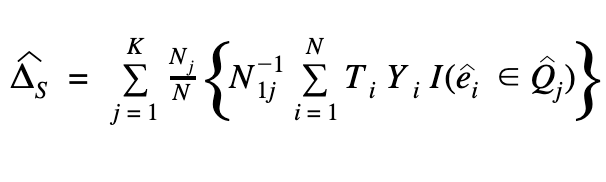

In [69]:
# Method to stratify data 
def stratify(df):
    
    Y = df['Y']
    D = df['A']
    scores = df['propensity_scores']
    
    # Create stratum and stratum limits
    Q1 = np.quantile(scores, .20)
    Q2 = np.quantile(scores, .40)
    Q3 = np.quantile(scores, .60)
    Q4 = np.quantile(scores, .80)
    Q5 = np.quantile(scores, 1.0)
    
    quin1 = df[df['propensity_scores']<= Q1]
    quin2 = df[(df['propensity_scores']> Q1) & (df['propensity_scores']<= Q2)]
    quin3 = df[(df['propensity_scores']> Q2) & (df['propensity_scores']<= Q3)]
    quin4 = df[(df['propensity_scores']> Q3) & (df['propensity_scores']<= Q4)]
    quin5 = df[df['propensity_scores']> Q4]

    quintiles = [quin1, quin2, quin3, quin4, quin5]
    Q_ranges = [None, Q1, Q2, Q3, Q4, Q5]

    return [quintiles, Q_ranges]

In [70]:
# Method to calc ATE
def strat_ATE(quintiles, Q_ranges):
    results = []
    N = sum([len(quintiles[0]),len(quintiles[1]),len(quintiles[2]),len(quintiles[3]),len(quintiles[4])])
    
    for i, stratum in enumerate(quintiles): 
        i+=1
        
        Nj = len(stratum)                      # Number of ind in stratum
        N1j = stratum['A'].value_counts()[1]   # Number of treated ind
        N0j = stratum['A'].value_counts()[0]   # Number of control ind
        
        sum1 = 0
        sum2 = 0

        # Summation of treated samples within strata
        sum1 = sum([Y*T for Y,T in zip(stratum['Y'],stratum['A'])])
        # Summation of untreated samples within strata
        sum2 = sum([(1-T)*Y for Y,T in zip(stratum['Y'],stratum['A'])]) 

        results.append(Nj/N * ((sum1/N1j)-(sum2/N0j)))

    return sum(results)

### 1. Reload data

In [71]:
lowDim_dataset = pd.read_csv('../data/lowDim_dataset.csv')
highDim_dataset = pd.read_csv('../data/highDim_dataset.csv')

### a. Low Dim data

In [72]:
lowDim_scores = pd.read_csv('../output/low_dim_propensity_scores.csv') 
lowDim_scores.insert( 1 , "Y" , lowDim_dataset['Y']) 
lowDim_scores.insert( 2 , "A" , lowDim_dataset['A'])

In [73]:
start = time.time()

quintiles , Q_ranges = stratify(lowDim_scores) 

lowDim_stratification_ATE = strat_ATE(quintiles ,Q_ranges)
end = time.time()
lowdim_strat_runtime = end - start
print( "Estimated ATE: " , lowDim_stratification_ATE)

Estimated ATE:  2.463529123502176


In [74]:
lowdim_strat_runtime = "{:,.3f}".format(lowdim_strat_runtime)
#lowDim_stratification_ATE = "{:,.3f}".format(lowDim_stratification_ATE)
#print(lowDim_stratification_ATE)
lowDim_stratification_error = abs(lowDim_stratification_ATE-lowDim_true_ATE)
lowDim_stratification_error = "{:,.3f}".format(lowDim_stratification_error)
print(lowDim_stratification_error)
print(lowdim_strat_runtime)

0.036
0.030


### b. High Dim Data

In [75]:
# Get Calculated Propensity Scores 
highDim_scores = pd.read_csv('../output/high_dim_propensity_scores.csv') 
highDim_scores.insert( 1 , "Y" , highDim_dataset['Y']) 
highDim_scores.insert( 2 , "A" , highDim_dataset['A'])

In [76]:
start = time.time()

quintiles , Q_ranges = stratify(highDim_scores)

highDim_stratification_ATE = strat_ATE(quintiles ,Q_ranges)

end = time.time()

In [77]:
highdim_strat_runtime="{:,.3f}".format(end-start)
#highDim_stratification_ATE = "{:,.3f}".format(highDim_stratification_ATE)
#print(highDim_stratification_ATE)
highDim_stratification_error = abs(highDim_stratification_ATE-highDim_true_ATE)
highDim_stratification_error = "{:,.3f}".format(highDim_stratification_error)
print(highDim_stratification_error)
print(highdim_strat_runtime)

0.010
0.018


## Step 6: Comparison

Finally, we have a table of all of the absolute errors and the runtimes for each method across the low dimensional and high dimensional datasets. Note that this notebook was run on a Mac with 64 GB of RAM and an i9 CPU, so the runtimes may be different if you run this notebook on your system.

We can see that the overall best method on the low dimensional dataset and the high dimensional dataset in terms of runtime and performance is stratification. The reason is because…

In [83]:
table = [["ATE Absolute Error",'Low Dim',lowDim_mahalanobis_error,lowDim_propensity_error,
         lowDim_linear_propensity_error,lowDim_ipw_error,lowDim_stratification_error],
        ["",'High Dim',highDim_mahalanobis_error,highDim_propensity_error,
         highDim_linear_propensity_error,highDim_ipw_error,highDim_stratification_error],
        ["Run Time (sec)",'Low Dim',lowDim_mahalanobis_runtime,lowDim_propensity_runtime,lowDim_linear_propensity_runtime,
         runtime_low_ipw, lowdim_strat_runtime],
        ["",'High Dim',highDim_mahalanobis_runtime,highDim_propensity_runtime,highDim_linear_propensity_runtime,
         runtime_high_ipw, highdim_strat_runtime]]

display(HTML(tabulate.tabulate(table, headers=["Metric","Dimension", "Full Matching-\nMahalanobis",
                                               "Full Matching-\nPropensity score", "Full Matching-\nLinear Propensity Score",
                                               "Inverse Propensity\nWeighting", 'Stratification'],
                                tablefmt='html')))

Metric,Dimension,Full Matching- Mahalanobis,Full Matching- Propensity score,Full Matching- Linear Propensity Score,Inverse Propensity Weighting,Stratification
ATE Absolute Error,Low Dim,0.414,0.888,0.976,1.661,0.036
,High Dim,1.446,0.292,0.232,1.153,0.01
Run Time (sec),Low Dim,0.633,28.145,1.924,0.145,0.03
,High Dim,79.957,6.956,48.447,0.779,0.018


## Reference Papers

Stuart E. A. (2010). Matching methods for causal inference: A review and a look forward. Statistical science : a review journal of the Institute of Mathematical Statistics, 25(1), 1–21. https://doi.org/10.1214/09-STS313

Chan, D., Ge, R., Gershony, O., Hesterberg, T., & Lambert, D. (2010). Evaluating online ad campaigns in a pipeline: causal models at scale. KDD '10.

Stuart, E. A., & Green, K. M. (2008). Using full matching to estimate causal effects in nonexperimental studies: examining the relationship between adolescent marijuana use and adult outcomes. Developmental psychology, 44(2), 395–406. https://doi.org/10.1037/0012-1649.44.2.395

McCaffrey, D. F., Ridgeway, G., & Morral, A. R. (2004). Propensity score estimation with boosted regression for evaluating causal effects in observational studies. Psychological methods, 9(4), 403–425. https://doi.org/10.1037/1082-989X.9.4.403

Raad, H., Cornelius, V., Chan, S., Williamson, E. and Cro, S., 2020. An evaluation of inverse probability weighting using the propensity score for baseline covariate adjustment in smaller population randomised controlled trials with a continuous outcome. BMC Medical Research Methodology, 20(1), pp.1-12. https://link.springer.com/article/10.1186/s12874-020-00947-7

Hansen, Ben B. Full matching in an observational study of coaching for the SAT. J. Amer. Statist. Assoc. 99 (2004), no. 467, 609–618.